In [1]:
import os
import cv2
import yaml
import random
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CocoDetection
from torchvision.models.detection import maskrcnn_resnet50_fpn, maskrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models import ResNet50_Weights
import torchvision.transforms as transforms
from torchvision.transforms import functional as F 
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from pycocotools.coco import COCO
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from coco_eval import CocoEvaluator
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from PIL import Image, ImageDraw
from datetime import datetime

In [2]:
NUM_EPOCHS = 100
NUM_WORKERS = 2
BATCH_SIZE = 4

# The amount the loss can change before counting as convergence 
EARLY_STOP_DELTA = 0.005
# The amount of epochs early stopping waits before aborting
EARLY_STOP_PATIENCE = 10
EARLY_STOP_LR_DECAY = 0.1

LEARNING_RATE = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0001
LR_STEP_SIZE = 30
LR_GAMMA = 0.1
MIN_LR = 1e-12

OUTPUT_DIR = f"out/pt_maskrcnn/run_{datetime.now().strftime("%Y_%m_%d_%H_%M_%S")}"
CHECKPOINTS_DIR = os.path.join(OUTPUT_DIR, "checkpoints")

In [3]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
print(f"outputting to {OUTPUT_DIR}")

outputting to out/pt_maskrcnn/run_2024_11_02_09_40_50


In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device {device}")

Using device cuda


In [5]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [6]:
def get_model_instance_segmentation(num_classes):
    model = maskrcnn_resnet50_fpn_v2(pretrained=False, num_classes=num_classes)
    return model
    
    model = maskrcnn_resnet50_fpn_v2(pretrained=True, weights_backbone=ResNet50_Weights.IMAGENET1K_V2)
    # Replace the box classifier with the desired number of classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Replace the mask predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    
    return model

In [7]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_file, root, split, transforms=None):
        self.dataset_file = dataset_file
        self.root = root
        with open(dataset_file) as f:
            self.dataset = yaml.safe_load(f)
        if split not in self.dataset:
            raise Error(f"Split not defined in {dataset_file}")
        self.split = split
        self.transforms = transforms
        self.data_dir = os.path.join(root, self.dataset["path"], self.dataset[split])
        if "images" in self.data_dir:
            self.data_dir = Path(self.data_dir).parent
        self.image_files = os.listdir(os.path.join(self.data_dir, "images"))
        self.label_files = os.listdir(os.path.join(self.data_dir, "labels"))

    def __getitem__(self, index):
        img = cv2.imread(os.path.join(self.data_dir, "images", self.image_files[index]))
        target = self.load_annotations(os.path.join(self.data_dir, "labels", self.label_files[index]), img.shape[:2], index)
        return img, target

    def __len__(self):
        return len(self.image_files)
    
    def relative_to_absolute_polygon(relative_polygon, image_width, image_height):
        # Convert relative coordinates to absolute by multiplying with image dimensions
        absolute_polygon = [
            (int(x * image_width), int(y * image_height)) for x, y in relative_polygon
        ]
        return absolute_polygon
                  
    def load_annotations(self, file, shape, idx):
        with open(file) as f:
            label_data = f.read().split("\n")
        boxes = []
        labels = []
        masks = []
        image_ids = []
        areas = []
        iscrowds = []
        for label_datum in label_data:
            class_id = label_data[0]
            bbox = np.array(label_data[1:5]).astype(np.float64)
            poly = np.array(label_data[5:]).astype(np.float64)

            #scale_mask = np.array([shape[0], shape[1]] * (len(poly) // 2 + 1))[:len(poly)]
            poly_scaled = relative_to_absolute_polygon(poly, shape[1], shape[0])

            poly_scaled = poly_scaled.reshape(-1, 2).reshape((-1, 1, 2)).astype(np.int32)

            mask = np.zeros(shape)
            cv2.fillPoly(mask, poly_scaled, 1)
            pixels = cv2.countNonZero(mask)
            image_area = shape[0] * shape[1]
            area_ratio = (pixels / image_area)
            mask = mask.astype(bool)
            
            labels.append(class_id)
            boxes.append(bbox)
            masks.append(mask)
            image_ids.append(idx * random.randint(0,2543))
            areas.append(area_ratio)
            iscrowds.append(False)
                                       
        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(class_ids, dtype=torch.int64),
            "masks": torch.tensor(masks, dtype=torch.uint8),  # Shape: (N, H, W)
            "image_id": torch.tensor(image_ids),
            "area": torch.tensor(areas, dtype=torch.float32),
            "iscrowd": torch.tensor(iscrowds, dtype=torch.int64)
        }
                                       
        return target

In [8]:
class CocoDataset(CocoDetection):
    def __init__(self, root, annFile, transforms=None):
        super(CocoDataset, self).__init__(root, annFile)
        self.transforms = transforms

    def __getitem__(self, idx):
        img, targets = super(CocoDataset, self).__getitem__(idx)

        # Extract image ID
        image_id = self.ids[idx]

        # Convert target information to a usable format
        boxes = []
        labels = []
        masks = []
        
        print(len(targets))

        for target in targets:
            # Each target is a tuple (mask, bbox, category_id)
            masks.append(self.coco.annToMask(target[0]))  # Extract mask from the first item
            boxes.append(target[1])  # Extract bounding box from the second item
            labels.append(target[2])  # Extract label from the third item

        # Convert to tensors
        target_dict = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "masks": torch.stack([torch.tensor(mask, dtype=torch.uint8) for mask in masks]),
            "image_id": torch.tensor([image_id]),
        }

        # Apply transformations if provided
        #if self.transforms:
        #    img = self.transforms(img)

        return img, target_dict

In [9]:
class CustomCocoDataset(CocoDetection):
    def __init__(self, root, annFile, transform=None):
        """
        Custom COCO dataset that loads images, bounding boxes, segmentation masks, 
        and category labels for each instance in an image.
        
        Args:
            root (str): Directory with all the images.
            annFile (str): Path to the COCO annotation file.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        super().__init__(root, annFile)
        self.transform = transform

    def __getitem__(self, index):
        """
        Returns an image along with its target annotations.

        Args:
            index (int): Index of the sample.

        Returns:
            image (torch.Tensor): Transformed image tensor.
            target (dict): Dictionary with keys:
                - 'boxes': Tensor of bounding boxes (N, 4).
                - 'labels': Tensor of category labels (N).
                - 'masks': Tensor of segmentation masks (N, H, W).
                - 'image_id': Tensor with a unique ID for the image.
                - 'area': Tensor of areas of the bounding boxes.
                - 'iscrowd': Tensor indicating if the instance is a crowd (1) or not (0).
        """
        # Load image and annotations
        img, annotations = super().__getitem__(index)
        
        # Convert image to tensor
        if self.transform:
            img = self.transform(img)
        else:
            img = F.to_tensor(img)  # Convert image to tensor
        
        # Initialize lists to hold instance data
        boxes = []
        labels = []
        masks = []
        area = []
        iscrowd = []
        ids = []
        
        if len(annotations) == 0:
            return img, {
                'boxes': torch.tensor([]),
                'labels': torch.tensor([]),
                'masks': torch.tensor([]),
                'image_id': torch.tensor([]),
                'area': torch.tensor([]),
                'iscrowd': torch.tensor([]),
                'ids': torch.tensor([])
            }

        for annotation in annotations:
            # Bounding box in [x, y, width, height]
            x, y, width, height = annotation['bbox']
            boxes.append([x, y, x + width, y + height])
            labels.append(annotation['category_id'])
            area.append(annotation['area'])
            iscrowd.append(annotation['iscrowd'])
            ids.append(annotation['id'])

            # Process segmentation
            mask = self._create_segmentation_mask(annotation, img.size(1), img.size(2))
            masks.append(mask)

        # Convert lists to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        if len(masks) == 0:
            masks = torch.tensor([])
        else:
            masks = torch.stack(masks, dim=0)
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)

        # Image ID
        image_id = torch.tensor([index])
        ids = torch.as_tensor(ids, dtype=torch.int64)

        # Create the target dictionary
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd,
            'ids': ids
        }

        return img, target

    def _create_segmentation_mask(self, annotation, height, width):
        """
        Creates a binary mask for a given instance's segmentation data.

        Args:
            annotation (dict): COCO annotation dictionary containing segmentation data.
            height (int): Height of the image.
            width (int): Width of the image.

        Returns:
            torch.Tensor: Binary mask tensor for the instance.
        """
        mask = Image.new("L", (width, height), 0)  # Create a blank mask
        for segmentation in annotation['segmentation']:
            # segmentation is a list of coordinates: [x1, y1, x2, y2, ..., xn, yn]
            if isinstance(segmentation, list):  # Polygon format
                poly = np.array(segmentation).reshape((-1, 2))
                ImageDraw.Draw(mask).polygon(poly.flatten().tolist(), outline=1, fill=1)
            # Additional processing may be added here for other segmentation formats
        #mask = np.fliplr(mask).copy()
        return F.to_tensor(mask)  # Convert mask to tensor

In [10]:
# Create train and validation datasets and loaders
#train_dataset = CustomDataset(root="_data/datasets", dataset_file="_data/synthetic.yaml", split="train", transforms=F.to_tensor)
#val_dataset = CustomDataset(root="_data/datasets", dataset_file="_data/synthetic.yaml", split="val", transforms=F.to_tensor)
input_transforms = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

train_dataset = CustomCocoDataset(root="_data/synthetic_leaf_instances/train/images", 
                              annFile="_data/coco_synthetic_train.json", 
                              transform=input_transforms)
val_dataset = CustomCocoDataset(root="_data/synthetic_leaf_instances/val/images", 
                            annFile="_data/coco_synthetic_val.json", 
                            transform=input_transforms)

loading annotations into memory...
Done (t=4.00s)
creating index...
index created!
loading annotations into memory...
Done (t=1.06s)
creating index...
index created!


torch.Size([3, 640, 640])
dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd', 'ids'])
{'boxes': tensor([[448., 266., 600., 371.],
        [341., 326., 585., 520.],
        [301.,  94., 389., 192.],
        [215., 108., 570., 206.],
        [458., 273., 523., 596.]]), 'labels': tensor([1, 1, 1, 1, 1]), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
  

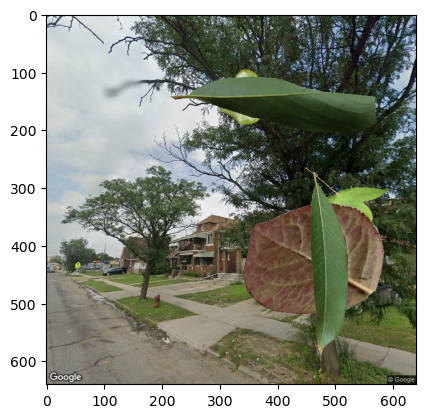

In [11]:
sample_img, sample_annos = next(iter(train_dataset))
print(sample_img.shape)
print(sample_annos.keys())
print(sample_annos)
plt.imshow(sample_img.numpy().transpose((1,2,0)))
plt.show()

In [12]:
train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS, 
                          shuffle=True,
                          collate_fn=lambda batch: tuple(zip(*batch)))
val_loader = DataLoader(val_dataset, 
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        shuffle=False,
                        collate_fn=lambda batch: tuple(zip(*batch)))

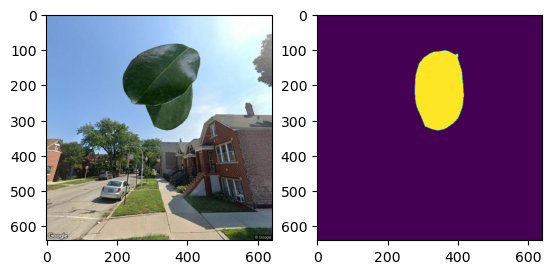

In [13]:
loader_sample = next(iter(train_loader))
# print(loader_sample)

plt.subplot(1,2,1)
plt.imshow(loader_sample[0][0].cpu().numpy().transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(loader_sample[1][0]['masks'][0].cpu().numpy().squeeze())
plt.show()

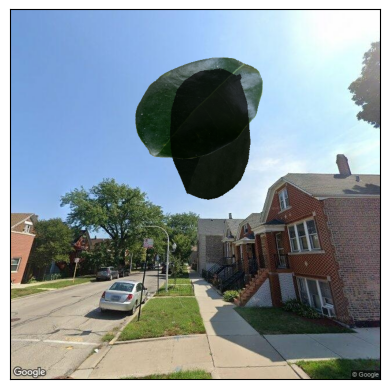

In [14]:
from torchvision.utils import draw_segmentation_masks
dogs_with_masks = [
    draw_segmentation_masks(img, masks=mask.to(dtype=torch.bool), alpha=0.7)
    for img, mask in zip(loader_sample[0], loader_sample[1][0]['masks'][0])
]
show(dogs_with_masks)

tensor([[277., 102., 416., 330.],
        [217.,  83., 437., 260.]])


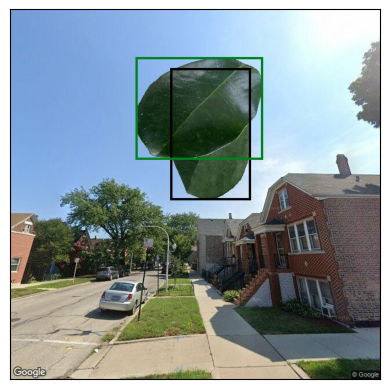

In [15]:
from torchvision.utils import draw_bounding_boxes
print(loader_sample[1][0]['boxes'])

boxes = draw_bounding_boxes(loader_sample[0][0], loader_sample[1][0]['boxes'], width=4)
show(boxes)

loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


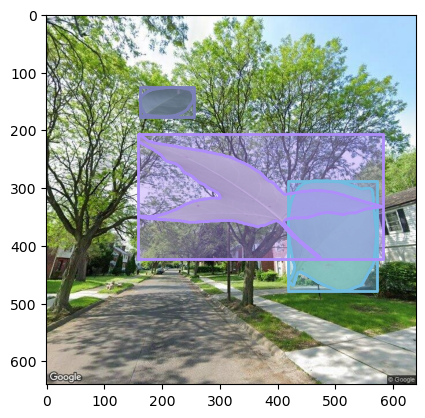

In [16]:
coco = COCO("_data/coco_synthetic_val.json")
IMG_ID = 11
img_info = coco.loadImgs([IMG_ID])[0]
img_file_name = img_info["file_name"]
img = cv2.imread(os.path.join("_data/synthetic_leaf_instances/val/images", img_file_name))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

ann_ids = coco.getAnnIds(imgIds=[IMG_ID], iscrowd=None)
anns = coco.loadAnns(ann_ids)

plt.imshow(img)
coco.showAnns(anns, draw_bbox=True)
plt.show()

In [17]:
def convert_to_coco_format(detections, image_ids, category_mapping):
    """
    Converts model detections to COCO results format.
    
    Args:
        detections (list of dict): List of detection results where each dict contains:
            - 'boxes': Tensor of shape (N, 4) with bounding boxes in [x_min, y_min, x_max, y_max]
            - 'labels': Tensor of shape (N,) with category labels
            - 'scores': Tensor of shape (N,) with confidence scores
        image_ids (list): List of image IDs corresponding to each detection.
        category_mapping (dict): Mapping from class indices to COCO category IDs.
        
    Returns:
        list: List of detections in COCO results format.
    """
    coco_results = []
    for i, det in enumerate(detections):
        image_id = image_ids[i]
        
        boxes = det['boxes'].cpu().numpy()  # Bounding boxes
        labels = det['labels'].cpu().numpy()  # Class labels
        scores = det['scores'].cpu().numpy()  # Confidence scores
        
        for j in range(len(boxes)):
            x_min, y_min, x_max, y_max = boxes[j]
            width = x_max - x_min
            height = y_max - y_min
            coco_results.append({
                'image_id': int(image_id),
                'category_id': int(category_mapping[labels[j]]),
                'bbox': [float(x_min), float(y_min), float(width), float(height)],
                'score': float(scores[j]),
                'mask': det['masks'].cpu().numpy()
            })
    
    return coco_results

In [18]:
# Evaluation function to compute metrics
coco_gt = COCO("_data/coco_synthetic_val.json")  # Load COCO annotations if you have them
def evaluate(model, data_loader, device):
    coco_evaluator = None
    losses = None
    
    with torch.no_grad():
        for images, targets in tqdm(data_loader):
            corrupt = False
            for target in targets:
                if len(target["boxes"]) == 0:
                    corrupt = True
                    break
            if corrupt:
                continue
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            model.train()
            batch_losses = model(images, targets)
            if losses is None:
                losses = batch_losses
            else:
                losses = {k: losses.get(k, 0) + batch_losses.get(k, 0) for k in set(losses) | set(batch_losses)}
            model.eval()
            outputs = model(images)
            
            # Collect outputs and ground-truth for coco-style evaluation
            if coco_evaluator is None:
                coco_evaluator = CocoEvaluator(coco_gt, iou_types=["bbox", "segm"])
            
            coco_evaluator.update(convert_to_coco_format(outputs, image_ids=[target['image_id'] for target in targets], category_mapping={1:1}))
        
        # Gather evaluation results
        coco_evaluator.synchronize_between_processes()
        coco_evaluator.accumulate()
        coco_evaluator.summarize()
        
        return coco_evaluator.coco_eval["segm"].stats, losses  # return segmentation stats

loading annotations into memory...
Done (t=1.00s)
creating index...
index created!


In [19]:
def coco_eval_to_dict(coco_eval):
    """
    Converts a COCOeval object to a dictionary format.

    Args:
        coco_eval (COCOeval): COCOeval object after evaluation.

    Returns:
        dict: Dictionary with COCO evaluation metrics.
    """
    stats = coco_eval
    
    eval_metrics = {
        'Average Precision (AP) @[ IoU=0.50:0.95 | area=all | maxDets=100 ]': stats[0],
        'Average Precision (AP) @[ IoU=0.50      | area=all | maxDets=100 ]': stats[1],
        'Average Precision (AP) @[ IoU=0.75      | area=all | maxDets=100 ]': stats[2],
        'Average Precision (AP) @[ IoU=0.50:0.95 | area=small | maxDets=100 ]': stats[3],
        'Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]': stats[4],
        'Average Precision (AP) @[ IoU=0.50:0.95 | area=large | maxDets=100 ]': stats[5],
        'Average Recall (AR) @[ IoU=0.50:0.95    | area=all | maxDets=1 ]': stats[6],
        'Average Recall (AR) @[ IoU=0.50:0.95    | area=all | maxDets=10 ]': stats[7],
        'Average Recall (AR) @[ IoU=0.50:0.95    | area=all | maxDets=100 ]': stats[8],
        'Average Recall (AR) @[ IoU=0.50:0.95    | area=small | maxDets=100 ]': stats[9],
        'Average Recall (AR) @[ IoU=0.50:0.95    | area=medium | maxDets=100 ]': stats[10],
        'Average Recall (AR) @[ IoU=0.50:0.95    | area=large | maxDets=100 ]': stats[11],
    }
    
    return eval_metrics

In [20]:
# Set up the model
num_classes = 2  # background + 1 foreground class (or adjust as needed)
model = get_model_instance_segmentation(num_classes)
model = model.to(device)

/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/stefan.steinheber/.conda/envs/pt_12.4/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [22]:
# Set up optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
optimizer = torch.optim.Adam(params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=MIN_LR)
#lr_scheduler_step = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP_SIZE, gamma=LR_GAMMA)

In [ ]:
# Training loop
metrics_df = pd.DataFrame()
training_df = pd.DataFrame()
loss_before = 50000
es_wait = 0
best_loss = 5000
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    p_bar = tqdm(enumerate(train_loader), desc=f"Training Epoch {epoch+1}", total=len(train_loader))
    total_corrupt = 0
    for i, data in p_bar:
        images, targets = data
        corrupt = False
        for target in targets:
            if len(target["boxes"]) == 0:
                corrupt = True
                break
        if corrupt:
            total_corrupt += 1
            continue
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        if i % 100:
            training_df = pd.concat([training_df, pd.DataFrame({key: loss.item() for key, loss in loss_dict.items()}, index=[epoch * len(train_loader) + i])])
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()
    
        p_bar.set_description(f"Training Epoch {epoch+1}, loss: {0 if not epoch_loss > 0 else (epoch_loss/(i+1)):.4f}, lr:{lr_scheduler.get_last_lr()[0]:.5f}, es-epochs: {es_wait}, corrupted: {total_corrupt}")
        
        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    # Step the scheduler
    lr_scheduler.step()
    
    mean_loss = epoch_loss/len(train_loader)
    
    # Print training loss
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {mean_loss:.4f}")
    
    # Evaluate on validation set and log metrics
    segm_stats, eval_losses = evaluate(model, val_loader, device)
    segm_stats_dict = coco_eval_to_dict(segm_stats)
    eval_losses = {key: value.item() / len(val_loader) for key,value in eval_losses.items()}
    eval_loss = sum(loss for loss in eval_losses.values())
    
#    segm_stats_dict['epoch'] = epoch
    metrics_df = pd.concat([metrics_df, pd.DataFrame({**segm_stats_dict, **eval_losses, 'val_loss_total': eval_loss}, index=[epoch])])
    print(f"Segmentation metrics (AP, AR) at epoch {epoch+1}: loss: {eval_loss} {segm_stats}")
    metrics_df.to_csv(os.path.join(OUTPUT_DIR, "metrics_eval.csv"))
    training_df.to_csv(os.path.join(OUTPUT_DIR, "metrics_train.csv"))
    
    torch.save(model, os.path.join(OUTPUT_DIR, "checkpoints", f"epoch_{epoch}.pt"))
    
    if eval_loss < best_loss:
        best_loss = eval_loss
        print(f"Found new best performing model")
        torch.save(model, os.path.join(OUTPUT_DIR, "checkpoints", f"best.pt"))
    
    # Check if early stopping conditions apply
    if loss_before - eval_loss  < EARLY_STOP_DELTA:
        es_wait += 1
    else:
        es_wait = 0
    if es_wait >= EARLY_STOP_PATIENCE:
        if lr_scheduler.get_last_lr() < MIN_LR:
            print("Early stopping: Aborting training!")
            break
        for g in optimizer.param_groups:
            g['lr'] *= EARLY_STOP_LR_DECAY  # Reduce lr by 1/10th
        es_wait = 0
                
    loss_before = eval_loss
    
torch.save(model, os.path.join(OUTPUT_DIR, f"final.pt"))
print("Finished training")

Training Epoch 1, loss: 0.8153, lr:0.00100, es-epochs: 0, corrupted: 203: 100%|██████████| 2000/2000 [06:09<00:00,  5.41it/s]


Epoch [1/100], Loss: 0.8153


100%|██████████| 500/500 [26:57<00:00,  3.23s/it]


Accumulating evaluation results...
DONE (t=0.60s).
Accumulating evaluation results...
DONE (t=0.60s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.274
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.629
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.192
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.292
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.112
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.433
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.358
 

Training Epoch 2, loss: 0.6438, lr:0.00100, es-epochs: 0, corrupted: 185:  89%|████████▉ | 1785/2000 [05:25<00:44,  4.80it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 500/500 [16:54<00:00,  2.03s/it]


Accumulating evaluation results...
DONE (t=0.63s).
Accumulating evaluation results...
DONE (t=0.50s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.393
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.755
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.372
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.412
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.466
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.515
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.484
 

Training Epoch 3, loss: 0.6241, lr:0.00100, es-epochs: 0, corrupted: 206: 100%|██████████| 2000/2000 [06:18<00:00,  5.29it/s]


Epoch [3/100], Loss: 0.6241


100%|██████████| 500/500 [16:01<00:00,  1.92s/it]


Accumulating evaluation results...
DONE (t=0.50s).
Accumulating evaluation results...
DONE (t=0.46s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.798
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.446
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.463
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.153
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.544
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.493
 

100%|██████████| 500/500 [25:00<00:00,  3.00s/it]ochs: 1, corrupted: 158:  79%|███████▉  | 1576/2000 [04:55<01:22,  5.14it/s]


Accumulating evaluation results...
DONE (t=0.62s).
Accumulating evaluation results...
DONE (t=0.57s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.354
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.695
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.373
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.135
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.429
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.488
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.401
 

Training Epoch 5, loss: 0.5876, lr:0.00100, es-epochs: 0, corrupted: 206: 100%|██████████| 2000/2000 [06:20<00:00,  5.25it/s]


Epoch [5/100], Loss: 0.5876


 74%|███████▎  | 368/500 [08:32<03:07,  1.42s/it]

# Test

In [33]:
import random
import os
import matplotlib.pyplot as plt

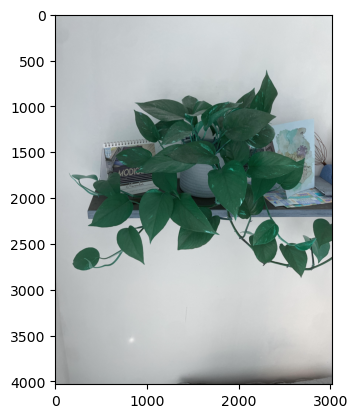

In [65]:
image_file = random.sample(os.listdir("_data/combined/test"), 1)[0]
image = cv2.imread(os.path.join("_data/combined/test", image_file))
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [66]:
image = cv2.resize(image, (640, 640))
model.eval()
pred = model(torch.as_tensor(image).permute((2, 0, 1)).unsqueeze(0).to(device, dtype=torch.float32))[0]

In [67]:
pred

{'boxes': tensor([[521.3168, 636.9023, 525.1402, 636.9139],
         [524.2491, 634.7258, 528.8796, 634.7361],
         [568.1252, 636.8087, 569.0705, 636.8661],
         [573.7145, 634.5751, 574.7172, 634.6092],
         [565.6027, 634.7681, 566.5432, 634.7965],
         [572.7975, 634.8912, 573.6591, 634.9225],
         [561.4966, 634.1591, 562.6594, 634.1863],
         [561.9987, 634.0816, 563.1235, 634.1148],
         [560.7637, 637.3694, 561.7106, 637.4343]], device='cuda:0',
        grad_fn=<StackBackward0>),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
 'scores': tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9871, 0.8530, 0.1172],
        device='cuda:0', grad_fn=<IndexBackward0>),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 

[521 636 525 636]
[524 634 528 634]
[568 636 569 636]
[573 634 574 634]
[565 634 566 634]
[572 634 573 634]
[561 634 562 634]
[561 634 563 634]
[560 637 561 637]


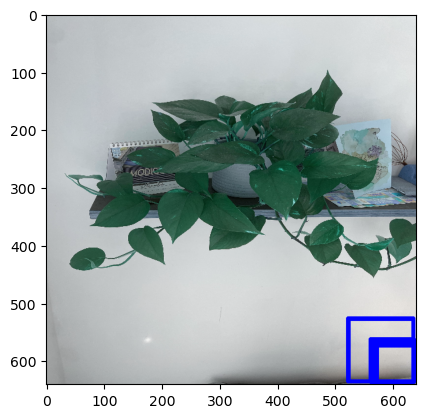

In [68]:
for box in pred['boxes']:
    box = box.detach().cpu().numpy().astype(np.int32)
    print(box)
    start = (box[0], box[2])
    end = (box[1], box[3])
    image = cv2.rectangle(image, start, end, (0, 0, 255), 3)
plt.imshow(image)
plt.show()